In [1]:
# coding=utf-8
"""
模型结果可视化相关代码
"""
from PIL import Image
import numpy as np
import os
import cv2
import scipy.misc
import matplotlib.pyplot as plt
import imageio
import colorsys
import random
from PIL import Image

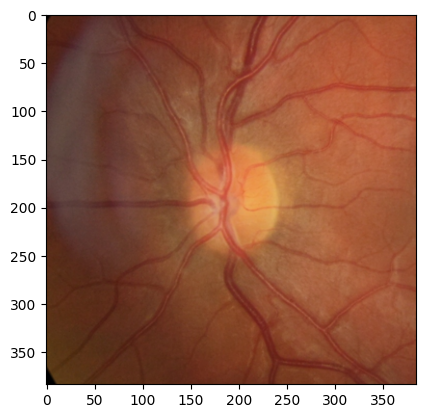

In [2]:
# 1.获取原始图像
image1='/home/zll/fedDG/xiaorong/0_best_epoch132/client6/0_sample12_img.npy'
ori_image = np.load(image1)
ori_image = ori_image.transpose(1, 2, 0) # 转化为（h,w,c)
# 2.打印原始图像以便于检查
plt.imshow(ori_image.astype('uint8'))
plt.show()

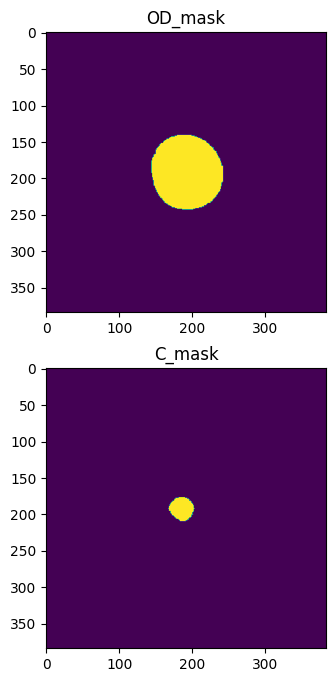

In [4]:
# 3.打印标签数据
image_mask = image1.replace("_img", "_gth")
# 形状为(2, 384, 384)
gth=np.load(image_mask) 
gth_cup = gth[0, ...] #视杯数据
gth_dic = gth[1, ...] #视盘数据

plt.figure(figsize=(14, 8))
plt.subplot(211)
plt.title('OD_mask')
plt.imshow(gth_dic.astype('uint8'))
plt.subplot(212)
plt.title('C_mask')
plt.imshow(gth_cup.astype('uint8'))
plt.show()
gth_cup = np.where(gth_cup[..., :] == 255, 1, 0)
gth_dic = np.where(gth_dic[..., :] == 255, 1, 0)

In [4]:
def Index_calculation_pixel(contours):
    #计算轮廓面积(计算第一个轮廓面积）
    area=cv2.contourArea(contours,oriented=False)
    #print('标签视盘轮廓面积: {}'.format(area))
    #计算轮廓周长
    length=cv2.arcLength(contours,closed=True)
    #print('标签视盘轮廓周长: {}'.format(length))
    roundness = (4 * math.pi * area) / (length * length)#圆形度
    #print('标签视盘轮廓圆形度: {}'.format(roundness))
    # 中心(x,y)，（宽度、高度）、旋转角度）
    rect = cv2.minAreaRect(contours)  # 最小外接矩形
    box = np.int0(cv2.boxPoints(rect))  # 矩形的四个角点取整
    #print(box)
    # 最小外接矩的长宽高度
    w = rect[1][0]
    #print( w)
    h= rect[1][1]
    #print(h)
    #print(w*h)
    return area,length,roundness,h,w,w*h

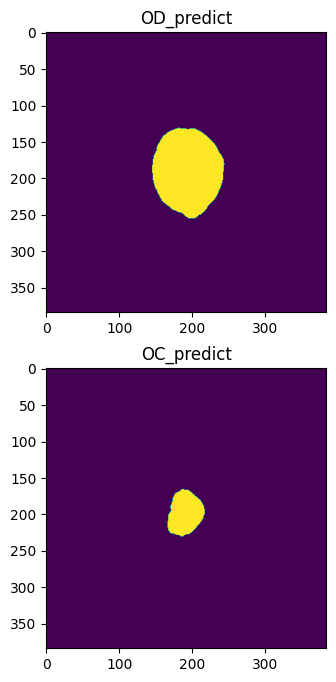

In [5]:
# 3.打印预测数据
image_pred = image1.replace("_img", "_pred")  # 发现问题1：视杯视盘的数组位置存反了
# 形状为(2, 384, 384)
pred=np.load(image_pred) 
pred_dic = pred[0, ...] #视盘数据
pred_cup = pred[1, ...] #视杯数据
plt.figure(figsize=(14, 8))
plt.subplot(211)
plt.title('OD_predict')
plt.imshow(pred_dic.astype('uint8'))
plt.subplot(212)
plt.title('OC_predict')
plt.imshow(pred_cup.astype('uint8'))
plt.show()

In [6]:
# 4.打印查看分割性能指标
dice_cup = 2*np.sum(gth_cup*pred_cup)/(np.sum(gth_cup+pred_cup))
dice_dic = 2*np.sum(gth_dic*pred_dic)/(np.sum(gth_dic+pred_dic))
print("hd_cup,dice_dic",dice_cup,dice_dic)


hd_cup,dice_dic 0.8103385511467055 0.9639616010071866


In [7]:
np.max(gth_dic)

1

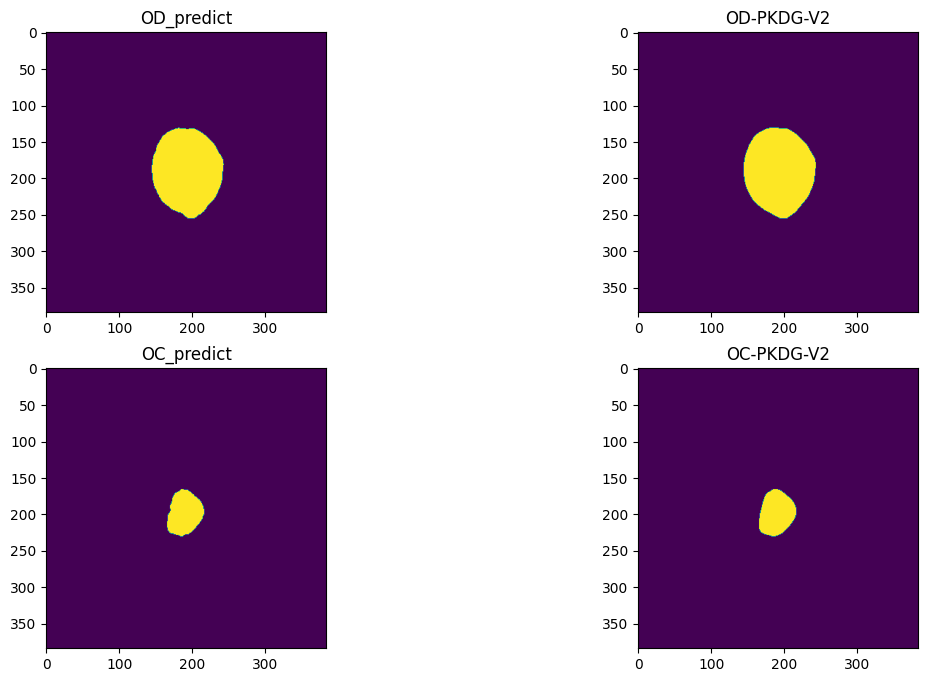

In [9]:
# 5.进行凸包检测
new_pred_dic=pred_dic.copy()
# new_pred_dic[(new_pred_dic >= 1)] = 255  # 二值化
# new_pred_dic[(new_pred_dic < 1)] = 0
pred_dic_contours, _ = cv2.findContours(new_pred_dic.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)  # 查找轮廓
if len(pred_dic_contours)==1:
    pred_dic_contour=pred_dic_contours[0]
else:
    max=0
    for i in range(0,len(pred_dic_contours)):
        print(len(pred_dic_contours[i]))
        #if len(pred_dic_contours[i])==152:
        if len(pred_dic_contours[i])>len(pred_dic_contours[max]):
            max=i
    pred_dic_contour=pred_dic_contours[max]

hull1 = cv2.convexHull(pred_dic_contour)  # 返回凸包中点的坐标
new_pred_dic=cv2.fillPoly(new_pred_dic, [hull1], color=(255, 255, 255))
# 归一化处理
new_pred_dic=(new_pred_dic-np.min(new_pred_dic))/(np.max(new_pred_dic)-np.min(new_pred_dic))

new_pred_cup=pred_cup.copy()
# new_pred_dic[(new_pred_dic >= 1)] = 255  # 二值化
# new_pred_dic[(new_pred_dic < 1)] = 0
pred_cup_contours, _ = cv2.findContours(new_pred_cup.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)  # 查找轮廓
# 问题2：存在中心点有空缺的，这里的轮廓要选择最大的
if len(pred_cup_contours)==1:
    pred_cup_contour=pred_cup_contours[0]
else:
    max=0
    for i in range(0,len(pred_cup_contours)):
        print(len(pred_cup_contours[i]))
        if len(pred_cup_contours[i])>len(pred_cup_contours[max]):
        
        #if len(pred_cup_contours[i])==76:
            
            
            max=i
        #print(len(pred_cup_contours[i]))
    pred_cup_contour=pred_cup_contours[max]

hull1 = cv2.convexHull(pred_cup_contour)  # 返回凸包中点的坐标
new_pred_cup=cv2.fillPoly(new_pred_cup, [hull1], color=(255, 255, 255))
# 归一化处理
new_pred_cup=(new_pred_cup-np.min(new_pred_cup))/(np.max(new_pred_cup)-np.min(new_pred_cup))

plt.figure(figsize=(14, 8))
plt.subplot(221)
#plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.title('OD_predict')
plt.imshow(pred_dic.astype('uint8'))
# cv2.imwrite('/home/zll/fedDG/xiaorong/0_best_epoch132/result/Unet-OD/test.png', pred_dic.astype('uint8')*255) 
plt.subplot(223)
#plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.title('OC_predict')
plt.imshow(pred_cup.astype('uint8'))

plt.subplot(222)
#plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.title('OD-PKDG-V2')
plt.imshow(new_pred_dic.astype('uint8'))
plt.subplot(224)
#plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.title('OC-PKDG-V2')
plt.imshow(new_pred_cup.astype('uint8'))
plt.show()

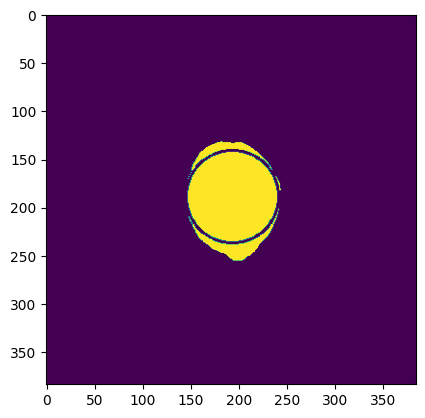

In [8]:
# 尝试找内接圆
new_pred_dic=pred_dic.copy()
contours,hierarchy = cv2.findContours(new_pred_dic.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros(new_pred_dic.shape,np.uint8)
cv2.drawContours(mask,contours,0,(255,255,255),-1)
# cv2.imshow('mask',mask) 
plt.imshow(mask.astype('uint8'))

dt = cv2.distanceTransform(mask,cv2.DIST_L2,5,cv2.DIST_LABEL_PIXEL)
transImg = cv2.convertScaleAbs(dt)
# cv2.normalize(transImg, transImg, 0, 255, cv2.NORM_MINMAX)
plt.imshow(transImg.astype('uint8'))

# cv2.imshow("distanceTransform", transImg)

_, max_val, _, max_loc = cv2.minMaxLoc(dt)
cv2.circle(new_pred_dic,max_loc, int(max_val),(0,0,255), 2)
plt.imshow(new_pred_dic.astype('uint8'))



In [9]:
dice_dic = 2*np.sum(gth_dic*new_pred_dic)/(np.sum(gth_dic+new_pred_dic))
dice_cup = 2*np.sum(gth_cup*new_pred_cup)/(np.sum(gth_cup+new_pred_cup))

In [10]:

dice_dic,dice_cup

(0.9595870052667258, 0.8090778097982709)

In [26]:
def plt_result_withimage(ori_image,image_name,gth_dic,gth_cup,pred_dic,pred_cup,new_pred_dic,new_pred_cup,result_pred,result_pred_new):
    ret, thresh = cv2.threshold(gth_dic.astype(np.uint8), 0.5, 255, 0)
    contours, im = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # 第一个参数是轮廓
    res1 = cv2.drawContours(ori_image.copy(), contours=contours, contourIdx=-1, color=(64, 224, 208), thickness=2)

    ret, thresh = cv2.threshold(gth_cup.astype(np.uint8), 0.5, 255, 0)
    contours, im = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # 第一个参数是轮廓
    res_gth = cv2.drawContours(res1.copy(), contours=contours, contourIdx=-1, color=(124, 252, 0), thickness=2)


    ret, thresh = cv2.threshold(pred_dic.astype(np.uint8), 0.5, 255, 0)
    contours, im = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # 第一个参数是轮廓
    res1 = cv2.drawContours(ori_image.copy(), contours=contours, contourIdx=-1, color=(64, 224, 208), thickness=2)

    ret, thresh = cv2.threshold(pred_cup.astype(np.uint8), 0.5, 255, 0)
    contours, im = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # 第一个参数是轮廓
    res_pred = cv2.drawContours(res1.copy(), contours=contours, contourIdx=-1, color=(124, 252, 0), thickness=2)

    ret, thresh = cv2.threshold(new_pred_dic.astype(np.uint8), 0.5, 255, 0)
    contours, im = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # 第一个参数是轮廓
    res1 = cv2.drawContours(ori_image.copy(), contours=contours, contourIdx=-1, color=(64, 224, 208), thickness=2)
    ret, thresh = cv2.threshold(new_pred_cup.astype(np.uint8), 0.5, 255, 0)
    contours, im = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # 第一个参数是轮廓
    res_pred_new = cv2.drawContours(res1.copy(), contours=contours, contourIdx=-1, color=(124, 252, 0), thickness=2)
    
    res_gth=cv2.cvtColor(res_gth,cv2.COLOR_BGR2RGB)
    res_pred_new=cv2.cvtColor(res_pred_new,cv2.COLOR_BGR2RGB)
    res_pred=cv2.cvtColor(res_pred,cv2.COLOR_BGR2RGB)
    
    filename='/home/zll/fedDG/output/0525_3/GT/'+image_name+'.png'
    cv2.imwrite(filename, res_gth.astype('uint8')) 
    filename='/home/zll/fedDG/output/0525_3/PKDG_V1/'+image_name+'.png'
    cv2.imwrite(filename, res_pred.astype('uint8')) 
    # filename='/home/zll/fedDG/output/0525_3/PKDG/'+image_name+'.png'
    # cv2.imwrite(filename, res_pred_new.astype('uint8')) 


    # plt.figure(figsize=(14, 8))
    # plt.subplot(131)
    # #plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
    # #原始图像
    # plt.title('Original image')
    # plt.imshow(res_gth.astype('uint8'))
    # plt.subplot(132)
    #plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
    # Unet
    # plt.title('初始分割图像')
    # plt.imshow(res_pred.astype('uint8'))
    # plt.subplot(133)
    # plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
    # PKDG-V2
    #plt.title('优化形状后的分割图像')
    #plt.imshow(res_pred_new.astype('uint8'))
    #plt.savefig("D:\pythonProject7\FedDG-ELCFS-main\output\未知域2\形状加原图对比图\\"+image_name+".png")
    #plt.show()



In [2]:
def plt_result(image_name,gth_dic,gth_cup,pred_dic,pred_cup,new_pred_dic,new_pred_cup,result_pred_cup,result_pred_dic,result_pred_cup_new,result_pred_dic_new):
    
    
    plt.figure(figsize=(14, 8))
    plt.subplot(231)
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
    plt.title('视盘_标签')
    plt.imshow(gth_dic.astype('uint8'))
    plt.subplot(234)
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
    plt.title('视杯_标签')
    plt.imshow(gth_cup.astype('uint8'))
    
    plt.subplot(232)
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
    plt.title('视盘_预测值')
    plt.imshow(pred_dic.astype('uint8'))
    plt.subplot(235)
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
    plt.title('视杯_预测值')
    plt.imshow(pred_cup.astype('uint8'))

    plt.subplot(233)
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
    plt.title('视盘_形状优化')
    plt.imshow(new_pred_dic.astype('uint8'))
    plt.subplot(236)
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
    plt.title('视杯_形状优化')
    plt.imshow(new_pred_cup.astype('uint8'))
    plt.savefig("D:\pythonProject7\FedDG-ELCFS-main\output\未知域2\形状优化对比图\\"+image_name+".png")
    #plt.show()


In [3]:
import math
import medpy.metric as metric

def Index_calculation_pixel(contours):
    #计算轮廓面积(计算第一个轮廓面积）
    area=cv2.contourArea(contours,oriented=False)
    #print('标签视盘轮廓面积: {}'.format(area))
    #计算轮廓周长
    length=cv2.arcLength(contours,closed=True)
    #print('标签视盘轮廓周长: {}'.format(length))
    roundness = (4 * math.pi * area) / (length * length)#圆形度
    #print('标签视盘轮廓圆形度: {}'.format(roundness))
    # 中心(x,y)，（宽度、高度）、旋转角度）
    rect = cv2.minAreaRect(contours)  # 最小外接矩形
    box = np.int0(cv2.boxPoints(rect))  # 矩形的四个角点取整
    #print(box)
    # 最小外接矩的长宽高度
    w = rect[1][0]
    #print( w)
    h= rect[1][1]
    #print(h)
    #print(w*h)
    return area,length,roundness,h,w,w*h


# 6.批量化处理数据
path = r'/home/zll/fedDG/output/VM_1/client1'
dice_cup_all=[]
dice_dic_all=[]
image_name_all=[]
new_dice_cup_all=[]
new_dice_dic_all=[]
hd_cup_all=[]
hd_dic_all=[]
new_hd_cup_all =[]
new_hd_dic_all =[]
asd_cup_all = []
asd_dic_all = []
new_asd_cup_all = []
new_asd_dic_all = []
mask_dic_area=[]
mask_dic_length=[]
mask_dic_roundness=[]
mask_dic_h=[]
mask_dic_w=[]
mask_dic_A=[]
mask_cup_area=[]
mask_cup_length=[]
mask_cup_roundness=[]
mask_cup_h=[]
mask_cup_w=[]
mask_cup_A=[]
new_dic_area=[]
new_dic_length=[]
new_dic_roundness=[]
new_dic_h=[]
new_dic_w=[]
new_dic_A=[]
new_cup_area=[]
new_cup_length=[]
new_cup_roundness=[]
new_cup_h=[]
new_cup_w=[]
new_cup_A=[]
for file in os.listdir(path):
    image1 = os.path.join(path, file)
    if image1.__contains__("img"):
        print(image1)
    else:
        continue
    # 1.获取原始图像
    ori_image = np.load(image1)
    ori_image = ori_image.transpose(1, 2, 0) # 转化为（h,w,c)
    # 2.获取标签数据
    image_mask = image1.replace("_img", "_gth")
    gth=np.load(image_mask)     # 形状为(2, 384, 384)
    gth_cup = gth[0, ...] #视杯数据mask
    gth_dic = gth[1, ...] #视盘数据mask
    gth_cup = np.where(gth_cup[..., :] == 255, 1, 0)
    gth_dic = np.where(gth_dic[..., :] == 255, 1, 0)
    
    gth_dic_contours, _ = cv2.findContours(gth_dic.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)  # 查找轮廓
    gth_cup_contours, _ = cv2.findContours(gth_cup.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)  # 查找轮廓
    area_gth_dic,length_gth_dic,roundness_gth_dic,h_gth_dic,w_gth_dic,A_gth_dic=Index_calculation_pixel(gth_dic_contours[0])
    area_gth_cup,length_gth_cup,roundness_gth_cup,h_gth_cup,w_gth_cup,A_gth_cup=Index_calculation_pixel(gth_cup_contours[0])
    
    mask_dic_area.append(area_gth_dic)
    mask_dic_length.append(length_gth_dic)
    mask_dic_roundness.append(roundness_gth_dic)
    mask_dic_h.append(h_gth_dic)
    mask_dic_w.append(w_gth_dic)
    mask_dic_A.append(A_gth_dic)
    
    mask_cup_area.append(area_gth_cup)
    mask_cup_length.append(length_gth_cup)
    mask_cup_roundness.append(roundness_gth_cup)
    mask_cup_h.append(h_gth_cup)
    mask_cup_w.append(w_gth_cup)
    mask_cup_A.append(A_gth_cup)
    
    
    
    # 3.获取预测数据
    image_pred = image1.replace("_img", "_pred")  # 发现问题1：视杯视盘的数组位置存反了
    pred=np.load(image_pred) # 形状为(2, 384, 384)
    pred_dic = pred[0, ...] #视盘数据predict
    pred_cup = pred[1, ...] #视杯数据predict
    # 4.进行形状优化
    new_pred_dic=pred_dic.copy()
    ret,thresh_dic=cv2.threshold(new_pred_dic.astype(np.uint8), 0, 255, cv2.THRESH_BINARY) #阈值设置 将图像转化为0，255的图像

    pred_dic_contours, _ = cv2.findContours(new_pred_dic.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)  # 查找轮廓
    # 视杯视盘只有一个的先验知识 轮廓只有一个
    # if len(pred_dic_contours)==1:
    #     pred_dic_contour=pred_dic_contours[0]
    # else:
    #     max=0
    #     for i in range(0,len(pred_dic_contours)):
    #         if len(pred_dic_contours[i])>len(pred_dic_contours[max]):
    #             max=i
    #     pred_dic_contour=pred_dic_contours[max]
        
    if len(pred_dic_contours)==1:
        pred_dic_contour=pred_dic_contours[0]
        
    # else:
    #     max=0
    #     for i in range(0,len(pred_cup_contours)):
    #         if len(pred_cup_contours[i])>len(pred_cup_contours[max]):
    #             max=i
    #         #print(len(pred_cup_contours[i]))
    #     pred_cup_contour=pred_cup_contours[max]
    else:
        max=0
        len_all=[len(pred_dic_contours[i]) for i in range(0,len(pred_dic_contours))]
        #print(len_all)
        max_val = np.max(len_all)
        max_idx = len_all.index(max_val) #获取轮廓最大的索引
        print("最大元素为", max_val, "其索引为", max_idx)
        len_diff=np.array(len_all-max_val)
        #print(len_diff)
        contours=np.where(len_diff >-40) #当差距小于某个阈值的轮廓才保留
        #print(contours[0][0])
        if len(contours[0])==1:
            pred_dic_contour=pred_dic_contours[contours[0][0]]  #只需保留最大的轮廓
        else:
            X_center=[]
            Y_center=[]
            #m_image=pred_cup.copy()
            for i in range(len(contours[0])):
                M = cv2.moments(pred_dic_contours[contours[0][i]])  # 计算第一条轮廓的各阶矩,字典形式
                center_x = int(M["m10"] / M["m00"])
                center_y = int(M["m01"] / M["m00"])
                #print(center_x,center_y)
                X_center.append(center_x)
                Y_center.append(center_y)
                for i in range(len(X_center)-1):
                    cv2.line(thresh_dic,(X_center[i],Y_center[i]),(X_center[i+1],Y_center[i+1]),255,5)
                cv2.line(thresh_dic,(X_center[0],Y_center[0]),(X_center[len(X_center)-1],Y_center[len(X_center)-1]),255,5) #将寻找到的轮廓点进行连接
                pred_dic_contours1, _ = cv2.findContours(thresh_dic, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # 只查找最里面的轮廓 
                len_all_1=[len(pred_dic_contours1[i]) for i in range(0,len(pred_dic_contours1))]
                max_val = np.max(len_all_1)
                max_idx = len_all_1.index(max_val)
                pred_dic_contour=pred_dic_contours1[max_idx]
                
    hull1 = cv2.convexHull(pred_dic_contour)  # 返回凸包中点的坐标
    new_pred_dic=cv2.fillPoly(new_pred_dic, [hull1], color=(255, 255, 255))
    new_pred_dic=(new_pred_dic-np.min(new_pred_dic))/(np.max(new_pred_dic)-np.min(new_pred_dic))    # 归一化处理
    
    new_dic_contours, _ = cv2.findContours(new_pred_dic.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)  # 查找轮廓
    area_new_dic,length_new_dic,roundness_new_dic,h_new_dic,w_new_dic,A_new_dic=Index_calculation_pixel(new_dic_contours[0])
    new_dic_area.append(area_new_dic)
    new_dic_length.append(length_new_dic)
    new_dic_roundness.append(roundness_new_dic)
    new_dic_h.append(h_new_dic)
    new_dic_w.append(w_new_dic)
    new_dic_A.append(A_new_dic)
      



    new_pred_cup=pred_cup.copy()
    ret,thresh_cup=cv2.threshold(new_pred_cup.astype(np.uint8), 0, 255, cv2.THRESH_BINARY) #阈值设置 将图像转化为0，255的图像
    pred_cup_contours, _ = cv2.findContours(new_pred_cup.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)  # 查找轮廓
    # 问题2：存在中心点有空缺的，这里的轮廓要选择合适的
    if len(pred_cup_contours)==1:
        pred_cup_contour=pred_cup_contours[0]
    else:
        max=0
        len_all=[len(pred_cup_contours[i]) for i in range(0,len(pred_cup_contours))]
        #print(len_all)
        max_val = np.max(len_all)
        max_idx = len_all.index(max_val) #获取轮廓最大的索引
        #print("最大元素为", max_val, "其索引为", max_idx)
        len_diff=np.array(len_all-max_val)
        #print(len_diff)
        contours=np.where(len_diff >-50) #当差距小于某个阈值的轮廓才保留
        #print(contours[0][0])
        if len(contours[0])==1:
            pred_cup_contour=pred_cup_contours[contours[0][0]]  #只需保留最大的轮廓
        # else:
        #     X_center=[]
        #     Y_center=[]
        #     #m_image=pred_cup.copy()
        #     for i in range(len(contours[0])):
        #         M = cv2.moments(pred_cup_contours[contours[0][i]])  # 计算第一条轮廓的各阶矩,字典形式
        #         center_x = int(M["m10"] / M["m00"])
        #         center_y = int(M["m01"] / M["m00"])
        #         #print(center_x,center_y)
        #         X_center.append(center_x)
        #         Y_center.append(center_y)
        #         for i in range(len(X_center)-1):
        #             cv2.line(thresh_cup,(X_center[i],Y_center[i]),(X_center[i+1],Y_center[i+1]),255,5)
        #         cv2.line(thresh_cup,(X_center[0],Y_center[0]),(X_center[len(X_center)-1],Y_center[len(X_center)-1]),255,5) #将寻找到的轮廓点进行连接
        #         pred_cup_contours1, _ = cv2.findContours(thresh_cup, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # 只查找最里面的轮廓 
        #         len_all_1=[len(pred_cup_contours1[i]) for i in range(0,len(pred_cup_contours1))]
        #         max_val = np.max(len_all_1)
        #         max_idx = len_all_1.index(max_val)
        #         pred_cup_contour=pred_cup_contours1[max_idx]

    hull2 = cv2.convexHull(pred_cup_contour)  # 返回凸包中点的坐标
    new_pred_cup=cv2.fillPoly(new_pred_cup, [hull2], color=(255, 255, 255))
    new_pred_cup=(new_pred_cup-np.min(new_pred_cup))/(np.max(new_pred_cup)-np.min(new_pred_cup))     # 归一化处理
    
    new_cup_contours, _ = cv2.findContours(new_pred_cup.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)  # 查找轮廓
    area_new_cup,length_new_cup,roundness_new_cup,h_new_cup,w_new_cup,A_new_cup=Index_calculation_pixel(new_cup_contours[0])
    new_cup_area.append(area_new_cup)
    new_cup_length.append(length_new_cup)
    new_cup_roundness.append(roundness_new_cup)
    new_cup_h.append(h_new_cup)
    new_cup_w.append(w_new_cup)
    new_cup_A.append(A_new_cup)
      
    
    #计算优化后的轮廓评价指标
    
    # 5.计算性能对比
    dice_cup = 2*np.sum(gth_cup*pred_cup)/(np.sum(gth_cup+pred_cup))
    dice_dic = 2*np.sum(gth_dic*pred_dic)/(np.sum(gth_dic+pred_dic))
    new_dice_dic = 2*np.sum(gth_dic*new_pred_dic)/(np.sum(gth_dic+new_pred_dic))
    new_dice_cup = 2*np.sum(gth_cup*new_pred_cup)/(np.sum(gth_cup+new_pred_cup))
    hd_cup = metric.binary.hd95(gth_cup, pred_cup)
    hd_dic = metric.binary.hd95(gth_dic, pred_dic)
    new_hd_cup = metric.binary.hd95(gth_cup, new_pred_cup)
    new_hd_dic = metric.binary.hd95(gth_dic, new_pred_dic)

    asd_cup = metric.binary.asd( pred_cup, gth_cup)
    asd_dic = metric.binary.asd( pred_dic, gth_dic)
    new_asd_cup = metric.binary.asd( new_pred_cup, gth_cup)
    new_asd_dic = metric.binary.asd( pred_dic, gth_dic)



    
    # print("Hausdorff Distance - cup:", haus_cup)
    # print("Hausdorff Distance - dic:", haus_dic)
    # print("New Hausdorff Distance - cup:", new_haus_cup)
    # print("New Hausdorff Distance - dic:", new_haus_dic)

    dice_cup_all.append(dice_cup)
    dice_dic_all.append(dice_dic)
    new_dice_cup_all.append(new_dice_cup)
    new_dice_dic_all.append(new_dice_dic)
    
    hd_cup_all.append(hd_cup)
    hd_dic_all.append(hd_dic)
    new_hd_cup_all.append(new_hd_cup)
    new_hd_dic_all.append(new_hd_dic)

    asd_cup_all.append(asd_cup)
    asd_dic_all.append(asd_dic)
    new_asd_cup_all.append(new_asd_cup)
    new_asd_dic_all.append(new_asd_dic)

    result_pred="OD dice:"+str(dice_dic)+" OC dice:"+str(dice_cup)
    result_pred_new="OD dice:"+str(new_dice_dic)+" OC dice:"+str(new_dice_cup)
    result_pred_cup="OC dice:"+str(dice_cup)
    result_pred_dic="OD dice:"+str(dice_dic)
    result_pred_cup_new="OC dice:"+str(new_dice_cup)
    result_pred_dic_new="OD dice:"+str(new_dice_dic)
    
    
    # 6.对结果进行可视化并保存
    image_name=file.split("_img")[0]
    image_name_all.append(image_name)
    
    # #plt_result(image_name,gth_dic,gth_cup,pred_dic,pred_cup,new_pred_dic,new_pred_cup,result_pred_cup,result_pred_dic,result_pred_cup_new,result_pred_dic_new)
    # plt_result_withimage(ori_image.copy(),image_name,gth_dic,gth_cup,pred_dic,pred_cup,new_pred_dic,new_pred_cup,result_pred,result_pred_new)

/home/zll/fedDG/output/VM_1/client1/1_sample92_img.npy
/home/zll/fedDG/output/VM_1/client1/1_sample98_img.npy
/home/zll/fedDG/output/VM_1/client1/1_sample32_img.npy
最大元素为 244 其索引为 2
/home/zll/fedDG/output/VM_1/client1/1_sample153_img.npy
最大元素为 239 其索引为 2
/home/zll/fedDG/output/VM_1/client1/1_sample109_img.npy
最大元素为 244 其索引为 1
/home/zll/fedDG/output/VM_1/client1/1_sample79_img.npy
/home/zll/fedDG/output/VM_1/client1/1_sample47_img.npy
/home/zll/fedDG/output/VM_1/client1/1_sample117_img.npy
最大元素为 267 其索引为 10
/home/zll/fedDG/output/VM_1/client1/1_sample12_img.npy
最大元素为 264 其索引为 11
/home/zll/fedDG/output/VM_1/client1/1_sample72_img.npy
最大元素为 213 其索引为 1
/home/zll/fedDG/output/VM_1/client1/1_sample19_img.npy
/home/zll/fedDG/output/VM_1/client1/1_sample125_img.npy
/home/zll/fedDG/output/VM_1/client1/1_sample51_img.npy
最大元素为 278 其索引为 3
/home/zll/fedDG/output/VM_1/client1/1_sample147_img.npy
最大元素为 298 其索引为 11
/home/zll/fedDG/output/VM_1/client1/1_sample151_img.npy
最大元素为 225 其索引为 1
/home/zll/fed

In [3]:
len(image_name_all)

400

In [6]:
import pandas as pd

df2= pd.DataFrame({'image':image_name_all,'OC dice':dice_cup_all,'New OC dice':new_dice_cup_all,'OD dice':dice_dic_all,'New OD dice':new_dice_dic_all,
'OC hd':hd_cup_all,'New OC hd':new_hd_cup_all,'OD hd':hd_dic_all,'New OD hd':new_hd_dic_all,
'OC asd':asd_cup_all,'New OC asd':new_asd_cup_all,'OD asd':asd_dic_all,'New OD asd':new_asd_dic_all,
                   '标签视盘面积':mask_dic_area,'标签视盘周长':mask_dic_length,'标签视盘圆形度':mask_dic_roundness,
                   "标签视盘外接矩形高":mask_dic_h,
                   "标签视盘外接矩形宽":mask_dic_w,
                   "标签视盘外接矩形面积":mask_dic_A,
                   '标签视杯面积':mask_cup_area,'标签视杯周长':mask_cup_length,
                   '标签视杯圆形度':mask_cup_roundness,
                   "标签视杯外接矩形高":mask_cup_h,
                   "标签视杯外接矩形宽":mask_cup_w,"标签视杯外接矩形面积":mask_cup_A,
                   '预测视盘面积':new_dic_area,'预测视盘周长':new_dic_length,
                   '预测视盘圆形度':new_dic_roundness,
                    "预测视盘外接矩形高":new_dic_h,
                   "预测视盘外接矩形宽":new_dic_w,
                   "预测视盘外接矩形面积":new_dic_A,
                    '预测视杯面积':new_cup_area,'预测视杯周长':new_cup_length,
                   '预测视杯圆形度':new_cup_roundness,
                   "预测视杯外接矩形高":new_cup_h,
                   "预测视杯外接矩形宽":new_cup_w,"预测视杯外接矩形面积":new_cup_A,})
df2.to_csv("/home/zll/fedDG/output/VM_3/client1/result_PKDG+VM_client1.csv",index=False)